<a href="https://colab.research.google.com/github/duducosmos/nurohcsr04/blob/main/netHCSR04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos instlar o tensorflow 2.0 e a ferramenta para converção do modelo que iremos gerar em código C++, a ser embarcado no ESP32.

In [ ]:
!pip install tensorflow==2.0
!apt-get -qq install xxd


Importando as bibliotecas necessárias 

In [5]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers


Agora devemos fazer o upload do arquivo contendo as informações de distância e tempo de respota do sensor.

In [6]:
from google.colab import files
uploaded = files.upload()

Saving dist.csv to dist.csv


In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Vamos cria um Pandas DataFrame para manipular os Dados e verificar possíveis outliers.

In [7]:
dist = pd.read_csv('dist.csv', delimiter=",")

In [8]:
dist.head()

,Unnamed: 0,distancia,duracao
0,0,10,141
1,1,10,141
2,2,10,141
3,3,10,141
4,4,10,141


In [9]:
dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  5000 non-null   int64
 1   distancia   5000 non-null   int64
 2   duracao     5000 non-null   int64
dtypes: int64(3)
memory usage: 117.3 KB


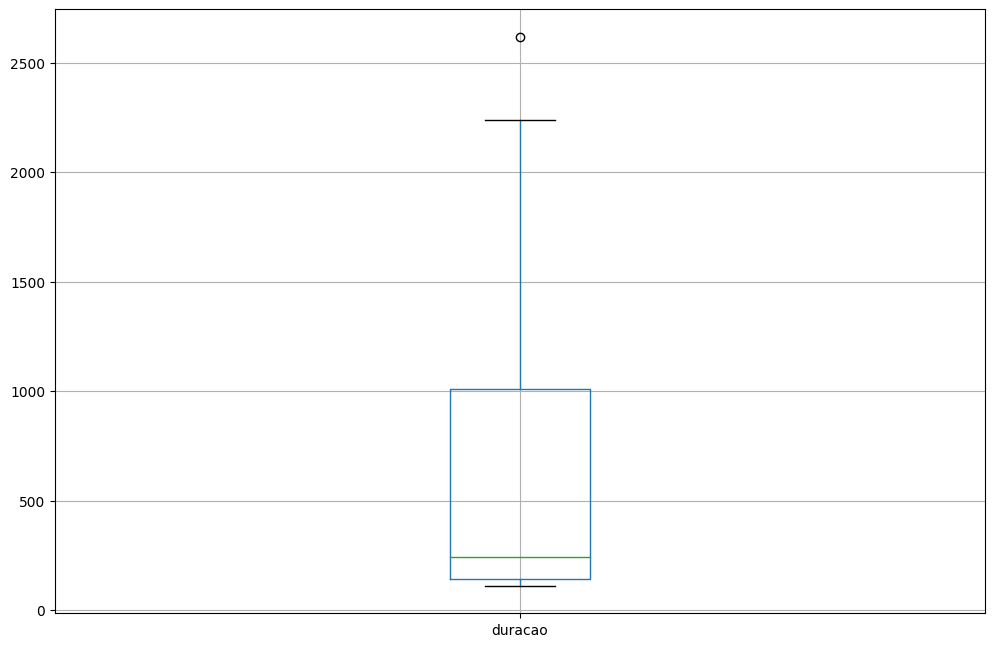

In [15]:
dist.boxplot(column=['duracao'])

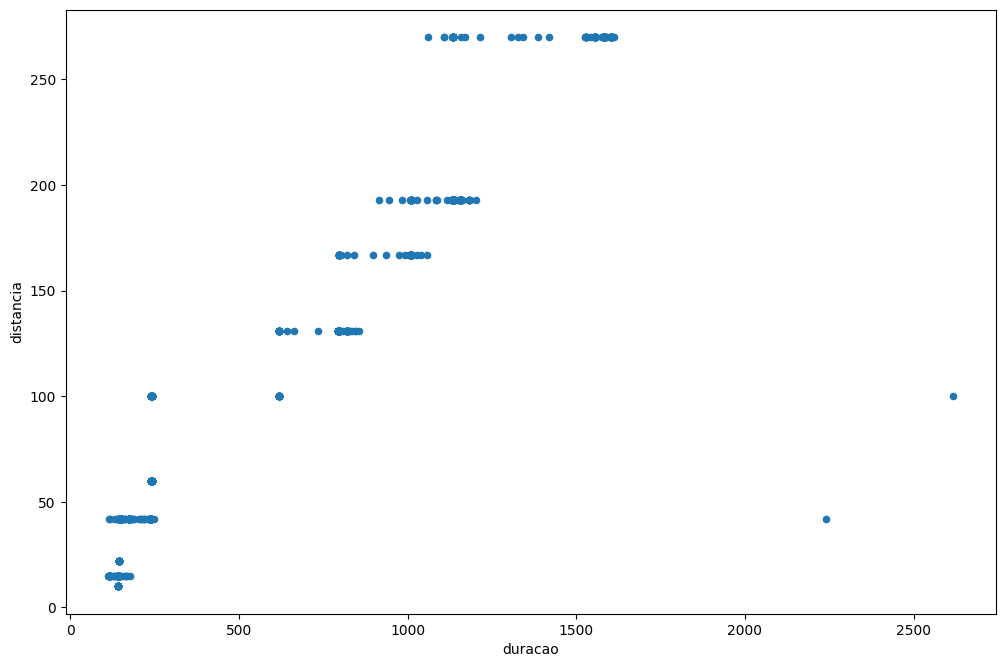

In [16]:
dist.plot(x='duracao', y='distancia', kind='scatter')

Nesse ponto, separamos o conjunto de dados em treinamento e teste. No primeiro momento, pegamos 40% dos dados originais para tetes. Os dados de testes dividimos em dados de teste e validação. A validação será realizada duranto o processo de treinamento.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dist['duracao'].to_numpy(), dist['distancia'].to_numpy(), test_size=0.40, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.30, random_state=1)

Criamos um gráfico para visualizar os três conjuntos de dados.

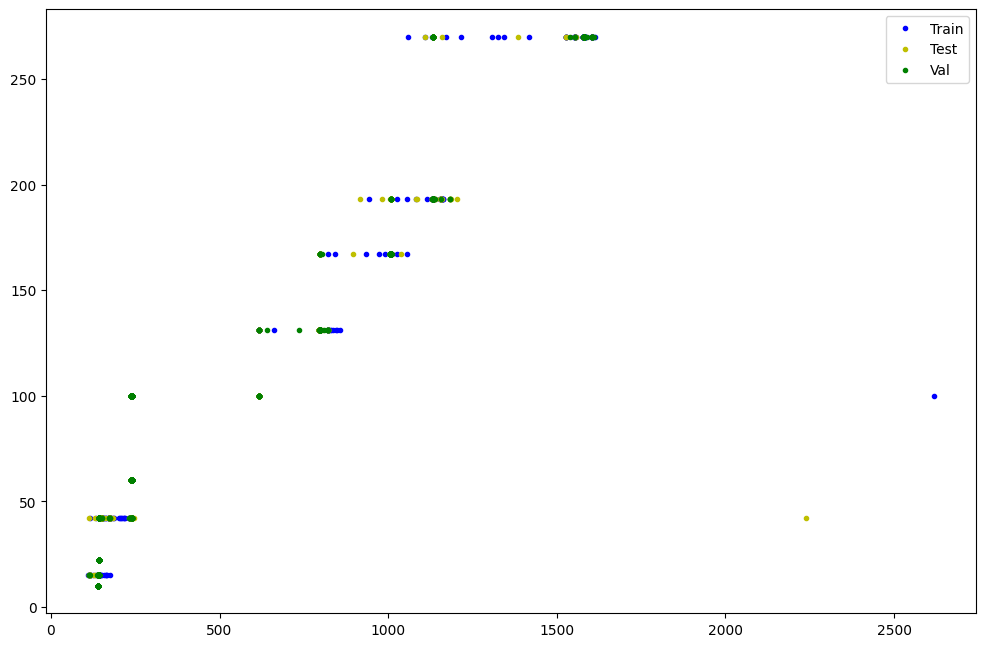

In [18]:
plt.plot(X_train, y_train,'b.', label='Train')
plt.plot(X_test, y_test, 'y.', label="Test")
plt.plot(X_val, y_val, 'g.', label="Val")
plt.legend()
plt.show()

O próximo passo será o de criar um modelo de rede neural. 
A rede será do típo sequência. A camada de entrada tem um neurônio, seguido por uma camada com dezesseis neurônioas, função de ativção RELU, e um nerônio na saída.

In [29]:
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
# model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


O gráfico abaixo é representativo do modelo.

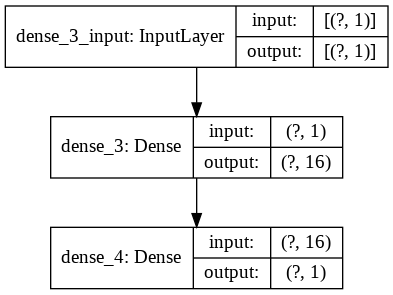

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [ ]:
hist = model.fit(X_train, y_train, epochs=1000, batch_size=500, validation_data=(X_val, y_val))

In [ ]:
Vamos avaliar o modelo com base nos dados de teste.

In [36]:
pred = model.predict(X_test)

In [ ]:
Faremos apenas uma inspeção visual aqui, plotando os dados previstos contra os dados reais.

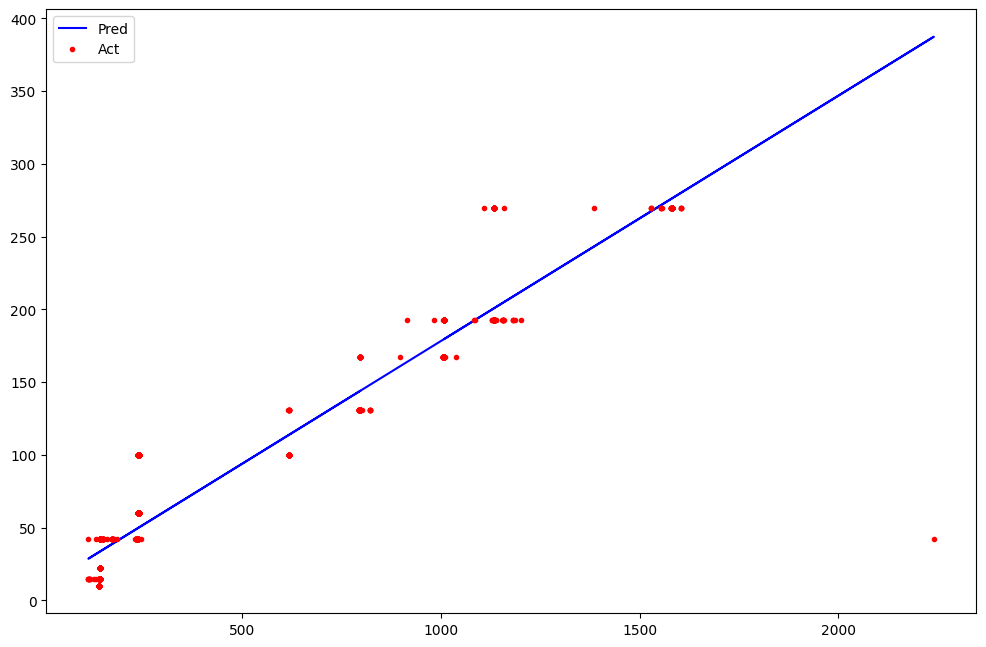

In [37]:
plt.plot(X_test, pred, 'b-', label='Pred')
plt.plot(X_test, y_test, 'r.', label='Act')
plt.legend()
plt.show()

A vantagem da rede neural para esse problema está com relação ao tratamento de variabilidade das medidas. No caso do sensor ultrassônico, utilizamos o fato de que a velocidade de propagação do som é constante. 
As imprecisões de medida de distância, ao utilizar o sensor ultrassônico, surgem de flutuações de tensão e qualidade do equipamento. É nesse ambiente de incerteza que as redes neurais são mais adequadas. 


Agora precisamos converter o modelo para o tensorflow lite.

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)


Faremos a optimização do modelo e iremos salvar nossa rede neural no formamo .tlite como nome hcsr04_1.tflite

In [42]:
converter.optimizations=[tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('hcsr04_1.tflite', 'wb').write(tflite_model)


1284

Para finalizar, vamos converter o modelo em códio C++ para ser embarcado no ESP32. 

In [43]:
!xxd -i hcsr04_1.tflite > hcsr04_1.cpp


Vamos exibir o conteúdo do arquivo no notebook, assim podemos copiar e colar o modelo no nosso projeto.

In [44]:
!cat hcsr04_1.cpp

unsigned char hcsr04_1_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0xc0, 0x04, 0x00, 0x00, 0x98, 0x01, 0x00, 0x00, 0x80, 0x01, 0x00, 0x00,
  0x34, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xe8, 0xfb, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x09, 0x00, 0x00, 0x00, 0x40, 0x01, 0x00, 0x00,
  0x2c, 0x01, 0x00, 0x00, 0xd4, 0x00, 0x00, 0x00, 0xcc, 0x00, 0x00, 0x00,
  0x7c, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xfa, 0xfe, 0xff, 0xff,
  0x04, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00, 0x31, 0x2e, 0x35, 0x2e,
  